## Fit baseline model using flight delay averages

- Takes the model input data for flight delays
- Split data based on external train/test data file
- Define baseline average model
- Evaluate model
- Save model as pickle
- -- save to mlflow -- 
- Write prediction prediction output to csv

### Parameters

-------------------
- `input_file`: Filepath of model input data of flight delays
- `train_test_file`: Filepath of train/test csv file with columns ["id", "model_set"]
- `output_file`: Filepath to write output csv file with minimal modelling input


### Returns

-----------------

Trained baseline model that simply predicts the average flight delay from the training
data in all predictions.


In [97]:
input_file = "../lvt-schiphol-assignment-snakemake/data/model_input/delays_base_input.csv"
train_test_file = "../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__sample.csv"

## Imports

In [98]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../")

from src.data.google_storage_io import read_csv_data, write_csv_data
from src.evaluation.regression import get_regression_metrics


In [99]:
# Read data

In [100]:
%%time
df = read_csv_data(model_input_file)
train_test = read_csv_data(train_test_file)

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/delays_base_input.csv

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__sample.csv

Wall time: 691 ms


In [121]:
%%time

def split_train_test(df, train_test, target="scheduleDelaySeconds"):
    # merge by `id` and group by train/test set labels
    df_set_groups = pd.merge(df, train_test, on="id", how="left").groupby("model_set")
    
    # get data per train/test set
    df_train, df_test = df_set_groups.get_group("train"), df_set_groups.get_group("test")
    
    # split target from features
    X_train, y_train = df_train.drop(columns=[target]), df_train[target]
    X_test, y_test = df_test.drop(columns=[target]),  df_test[target]
    
    print(f"""
        Split data shapes
        Input: {df.shape}
        Train: {X_train.shape},\t {y_train.shape} 
        Test:  {X_test.shape},\t {y_test.shape}
        """)
    
    # assert that we haven't dropped values at this stage
    # failed assert could indicate duplicate ids found in the data
    assert (len(X_train) + len(X_test)) == len(df)
    
    return X_train, X_test, y_train, y_test

# split data
X_train, X_test, y_train, y_test = split_train_test(df, train_test)




        Split data shapes
        Input: (477778, 8)
        Train: (382222, 8),	 (382222,) 
        Test:  (95556, 8),	 (95556,)
        
Wall time: 531 ms


# Prediction model

## Define model

In [122]:
class AverageBaseline(BaseEstimator):
    def __init__(self):
        self._average_y = None
   
    @property
    def average_y(self):
        return self._average_y
    
    def fit(self, X, y):
        """calculate the average values of `y` and save  internally"""
        self._average_y = np.mean(y)
        return self
    
    def predict(self, X):
        """return trained average y value for all observations in X"""
        return np.array([self.average_y] * X.shape[0])

## Train model

In [123]:
# train
avg_baseline = AverageBaseline().fit(X_train, y_train)

# Evaluate model

In [124]:
# predict
preds_train = avg_baseline.predict(X_train) 
preds_test = avg_baseline.predict(X_test)
preds_test

array([859.89174877, 859.89174877, 859.89174877, ..., 859.89174877,
       859.89174877, 859.89174877])

### Calculate regression metrics

In [105]:
# calculate regression metrics
train_metrics = get_regression_metrics(y_train, preds_train) 
test_metrics = get_regression_metrics(y_test, preds_test)

metrics_dict = dict(
    train = train_metrics,
    test_ = test_metrics)
metrics_dict

{'train': {'mae': 887.8160111885779,
  'mse': 4933016.394846443,
  'rmse': 2221.03948520652,
  'mape': inf,
  'median_absolute_error': 640.1082512257275,
  'max_error': 280261.1082512257,
  'explained_variance': 0.0,
  'r2_score': 0.0,
  'wce': 170333770.54553235},
 'test_': {'mae': 887.2240024211528,
  'mse': 4859640.220867962,
  'rmse': 2204.4591674304065,
  'mape': inf,
  'median_absolute_error': 642.8917487742725,
  'max_error': 167745.10825122573,
  'explained_variance': 0.0,
  'r2_score': -1.458987120006583e-07,
  'wce': 42519488.54168087}}

## Plot some prediction results

In [106]:
def datetime_to_date(dt):
    return pd.to_datetime(dt, utc=True).dt.date

def datetime_to_date_hour(dt):
    return pd.to_datetime(dt, utc=True).dt.floor('H')

In [107]:
def make_predictions_dataframe(model, 
                               X_train, X_test,
                               y_train, y_test,
                               X_val = None, y_val = None):
    preds_train = model.predict(X_train) 
    preds_test = model.predict(X_test)
    
    
    df_preds_train = X_train[["id", "scheduleDateTime"]] \
        .assign(
            y = y_train,
            yhat = preds_train,
            error = preds_train - y_train,
            model_set = "train")
    
    df_preds_test = X_test[["id", "scheduleDateTime"]] \
        .assign(
            y = y_test,
            yhat = preds_test,
            error = preds_test - y_test,
            model_set = "test")
    
    df_preds = pd.concat([df_preds_train, df_preds_test])
    return df_preds

df_predictions = make_predictions_dataframe(avg_baseline, X_train, X_test, y_train, y_test)
df_predictions

,id,scheduleDateTime,y,yhat,error,model_set
0,123414481790510775,2018-01-01 03:30:00+01:00,-480.0,859.891749,1339.891749,train
1,123414479288269149,2018-01-01 06:00:00+01:00,-98.0,859.891749,957.891749,train
2,123414479666542945,2018-01-01 06:05:00+01:00,-300.0,859.891749,1159.891749,train
3,123414479288365061,2018-01-01 06:05:00+01:00,-300.0,859.891749,1159.891749,train
4,123414479288274329,2018-01-01 06:15:00+01:00,694.0,859.891749,165.891749,train
...,...,...,...,...,...,...
477758,124763273490146855,2018-07-12 17:20:00+02:00,423.0,859.891749,436.891749,test
477763,124763272032454817,2018-07-12 17:20:00+02:00,423.0,859.891749,436.891749,test
477766,124763275285891757,2018-07-12 17:20:00+02:00,423.0,859.891749,436.891749,test
477770,124763270368084709,2018-07-12 17:25:00+02:00,80.0,859.891749,779.891749,test


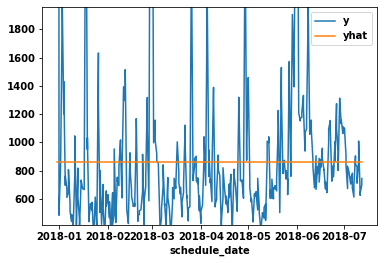

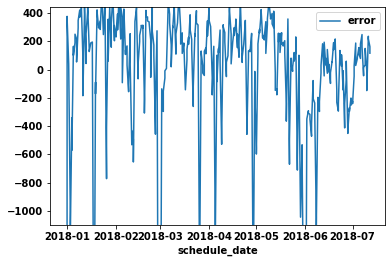

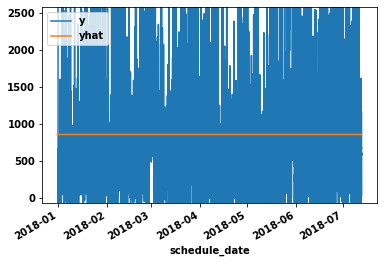

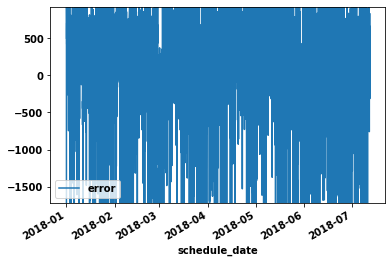

In [108]:
def predictions_daily_mean(df_predictions):
    df_predictions["schedule_date"] = datetime_to_date(df_predictions["scheduleDateTime"])
    df_predictions = df_predictions.drop(columns="id")
    df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
    return df_daily_mean

def predictions_hourly_mean(df_predictions):
    df_predictions["schedule_date"] = datetime_to_date_hour(df_predictions["scheduleDateTime"])
    df_predictions = df_predictions.drop(columns="id")
    df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
    return df_daily_mean

def get_safe_ylim(y, q=0.05, q2=None):
    if q2 is None:
        q2 = 1 - q
    return (np.quantile(y, q), np.quantile(y, q2))


df_daily_mean = predictions_daily_mean(df_predictions)
y_ylim = get_safe_ylim(df_daily_mean["y"])
error_ylim = get_safe_ylim(df_daily_mean["error"])

df_daily_mean[["schedule_date", "y", "yhat"]].plot(x="schedule_date", ylim=y_ylim)
df_daily_mean[["schedule_date", "error"]].plot(x="schedule_date", ylim=error_ylim)

df_hourly_mean = predictions_hourly_mean(df_predictions)
y_ylim = get_safe_ylim(df_hourly_mean["y"])
error_ylim = get_safe_ylim(df_hourly_mean["error"])

df_hourly_mean[["schedule_date", "y", "yhat"]].plot(x="schedule_date", ylim=y_ylim)
df_hourly_mean[["schedule_date", "error"]].plot(x="schedule_date", ylim=error_ylim)